Set OBSGEO-B to    -6.423449 from OBSGEO-[XYZ].
Set OBSGEO-H to 1338407622.672 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-09T20:12:50.680' from MJD-AVG.
Set DATE-END to '2023-09-09T22:16:17.386' from MJD-END'. [astropy.wcs.wcs]
[INFO] 542 x 71 x 75 Cube (/Users/mary/Fits image of JWST/ngc6302_ch4-short_s3d.fits)
[INFO] .data(542 x 71 x 75) (MJy / sr), no noise
[INFO] center:(-37:06:12.7324368,-06:46:15.666309) size:(24.850",26.250") step:(0.350",0.350") rot:-0.0 deg frame:ICRS
[INFO] wavelength: min:17.70 max:20.95 step:0.01 um


Wavelength range in data cube: 17.70300076296553 - 20.94900079118088 μm
Filtered Wavelengths: [19.00500077 19.01100077 19.01700077 19.02300077 19.02900077 19.03500077
 19.04100077 19.04700077 19.05300077 19.05900077 19.06500077 19.07100077
 19.07700077 19.08300077 19.08900078 19.09500078 19.10100078 19.10700078
 19.11300078 19.11900078 19.12500078 19.13100078 19.13700078 19.14300078
 19.14900078 19.15500078 19.16100078 19.16700078 19.17300078 19.17900078
 19.18500078 19.19100078 19.19700078 19.20300078 19.20900078 19.21500078
 19.22100078 19.22700078 19.23300078 19.23900078 19.24500078 19.25100078
 19.25700078 19.26300078 19.26900078 19.27500078 19.28100078 19.28700078
 19.29300078 19.29900078 19.30500078 19.31100078 19.31700078 19.32300078
 19.32900078 19.33500078 19.34100078 19.34700078 19.35300078 19.35900078
 19.36500078 19.37100078 19.37700078 19.38300078 19.38900078 19.39500078
 19.40100078 19.40700078 19.41300078 19.41900078 19.42500078 19.43100078
 19.43700078 19.44300078 19.44

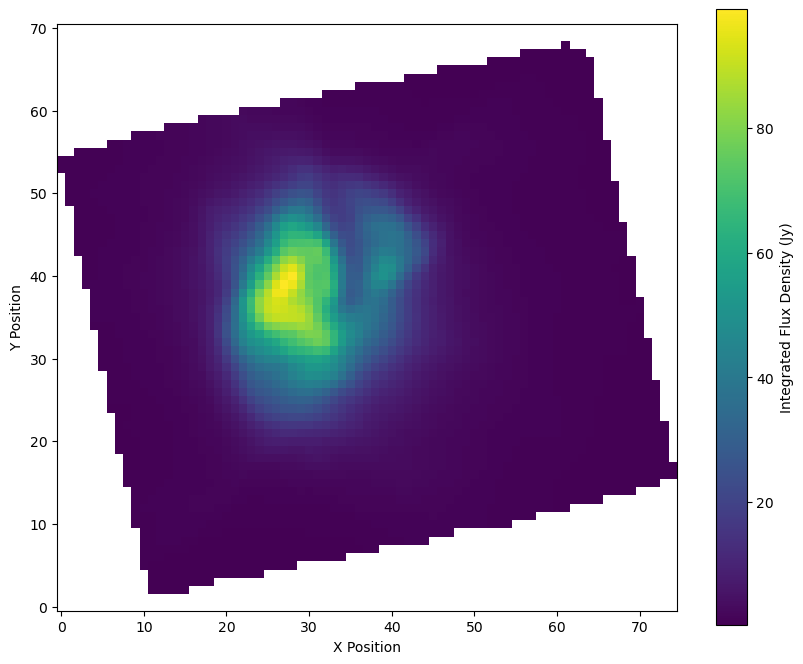

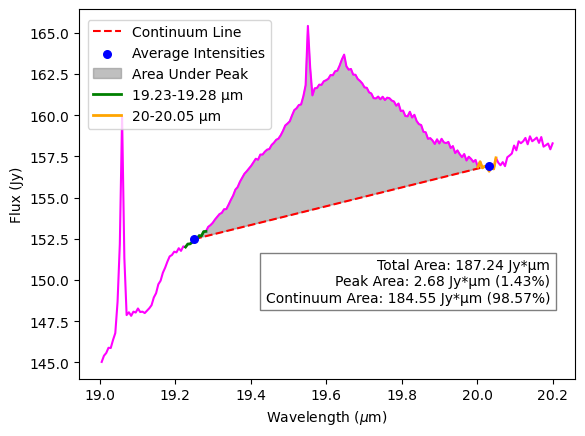

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from mpdaf.obj import Cube
from astropy.io import fits

obj1 = Cube('/Users/mary/Fits image of JWST/ngc6302_ch4-short_s3d.fits')
obj1.info()

pixel_size = obj1.wcs.get_step(unit=u.arcsec)[0] 
solid_angle = (pixel_size * u.arcsec).to(u.rad)**2

def process_slices_in_range(cube, solid_angle, wavelength_min, wavelength_max):
    wavelength = cube.wave.coord()
    print(f"Wavelength range in data cube: {wavelength.min()} - {wavelength.max()} μm")
    
    mask = (wavelength >= wavelength_min) & (wavelength <= wavelength_max)
    filtered_wavelengths = wavelength[mask]
    print(f"Filtered Wavelengths: {filtered_wavelengths}")
    
    integrated_flux_density_map = np.zeros((cube.shape[1], cube.shape[2]))
    for i in range(cube.shape[0]):
        if mask[i]:
            integrated_flux_density_map += cube.data[i, :, :] * solid_angle.value * 1e6

    if np.all(integrated_flux_density_map == 0):
        return

    plt.figure(figsize=(10, 8))
    plt.imshow(integrated_flux_density_map, cmap='viridis', origin='lower')
    plt.colorbar(label='Integrated Flux Density (Jy)')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'')
    plt.savefig('19integrated_flux_density_map_filtered.png', dpi=300, bbox_inches='tight')
    plt.show()

    filtered_flux_density = np.zeros(len(filtered_wavelengths))
    for i, wl in enumerate(filtered_wavelengths):
        filtered_flux_density[i] = np.sum(cube.data[mask][i, :, :]) * solid_angle.value * 1e6

  
    mask_start = (filtered_wavelengths >= 19.23) & (filtered_wavelengths <= 19.28)
    continuum_start = np.mean(filtered_flux_density[mask_start])

    mask_end = (filtered_wavelengths >= 20) & (filtered_wavelengths <= 20.05)
    continuum_end = np.mean(filtered_flux_density[mask_end])

    wavelengths = [19.25, 20.03]
    average_intensities = [continuum_start, continuum_end]

   
    continuum_line = np.interp(filtered_wavelengths, wavelengths, average_intensities)

    plt.figure()
    plt.plot(filtered_wavelengths, filtered_flux_density, color='magenta')
    plt.plot([19.25, 20.03], [continuum_start, continuum_end], label='Continuum Line', color='red', linestyle='--')
    plt.scatter(wavelengths, average_intensities, color='blue', s=30,zorder=5,label='Average Intensities')
 
 
    wavelength_condition = (filtered_wavelengths >= 19.25) & (filtered_wavelengths <= 20.03)

 
    plt.fill_between(filtered_wavelengths, filtered_flux_density, continuum_line, 
                     where=(filtered_flux_density > continuum_line) & wavelength_condition, 
                     color='gray', alpha=0.5, label='Area Under Peak')

    total_area = np.trapz(filtered_flux_density, filtered_wavelengths)
    continuum_area = np.trapz(continuum_line, filtered_wavelengths)
    peak_area = total_area - continuum_area

    peak_area_percentage = (peak_area / total_area) * 100
    continuum_area_percentage = (continuum_area / total_area) * 100

    annotation_text = (f'Total Area: {total_area:.2f} Jy*μm\n'
                       f'Peak Area: {peak_area:.2f} Jy*μm ({peak_area_percentage:.2f}%)\n'
                       f'Continuum Area: {continuum_area:.2f} Jy*μm ({continuum_area_percentage:.2f}%)')
    plt.annotate(annotation_text, xy=(0.95, 0.2), xycoords='axes fraction', fontsize=10, color='black',
                 ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.5))

    idx_22_2 = np.argmin(np.abs(filtered_wavelengths - 19.23))
    idx_22_4 = np.argmin(np.abs(filtered_wavelengths - 19.28))
    plt.plot(filtered_wavelengths[idx_22_2:idx_22_4 + 1], filtered_flux_density[idx_22_2:idx_22_4 + 1], color='green', linestyle='-', linewidth=2, label='19.23-19.28 μm')

    idx_23_9 = np.argmin(np.abs(filtered_wavelengths - 20))
    idx_24_1 = np.argmin(np.abs(filtered_wavelengths - 20.05))
    plt.plot(filtered_wavelengths[idx_23_9:idx_24_1 + 1], filtered_flux_density[idx_23_9:idx_24_1 + 1], color='orange', linestyle='-', linewidth=2, label='20-20.05 μm')
    plt.legend(loc='upper right', bbox_to_anchor=(0.4, 0.99))
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Flux (Jy)')
    plt.title('')
    plt.savefig('19111.png', dpi=300, bbox_inches='tight')
    plt.show()

process_slices_in_range(obj1, solid_angle, 19, 20.2)



